**Reinforcement Learning - Deep Q-Network (DQN) for LunarLander**

**Author:** Rhishi Kumar Ayyappan

**Objective:** To implement a Deep Q-Network (DQN) agent from scratch to master the LunarLander-v3 environment. The project's goal is to train the AI agent purely through reinforcement learning (trial-and-error with rewards) to successfully land the lunar module. The final analysis proves the agent's success with a rolling average score well above the 'solved' threshold of 200.

--- Section 1: Installs and Imports ---
Installing libraries: swig, gymnasium[box2d], pygame, imageio...
TensorFlow Version: 2.19.0
Gymnasium Version: 1.2.1
Imports complete.


--- Section 2: Constants and Environment Inspection ---
State Size: 8
Action Size: 4


--- Section 3: Defining the Replay Buffer ---
ReplayBuffer class defined.


--- Section 4: Defining the Q-Network ---


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,996 (19.52 KB)

 Trainable params: 4,996 (19.52 KB)

 Non-trainable params: 0 (0.00 B)



--- Section 5: Starting DQN Training Loop ---
Will train for a max of 800 episodes...
The environment is 'solved' when the avg score over 100 episodes is >= 200.
Episode:    1 | Score: -206.61 | Avg Score-100: -206.61 | Epsilon: 0.995
Episode:    2 | Score: -125.27 | Avg Score-100: -165.94 | Epsilon: 0.990
Episode:    3 | Score: -53.44 | Avg Score-100: -128.44 | Epsilon: 0.985
Episode:    4 | Score: -57.68 | Avg Score-100: -110.75 | Epsilon: 0.980
Episode:    5 | Score: -117.60 | Avg Score-100: -112.12 | Epsilon: 0.975
Episode:    6 | Score: -329.57 | Avg Score-100: -148.36 | Epsilon: 0.970
Episode:    7 | Score:  11.46 | Avg Score-100: -125.53 | Epsilon: 0.966
Episode:    8 | Score: -306.54 | Avg Score-100: -148.16 | Epsilon: 0.961
Episode:    9 | Score: -225.67 | Avg Score-100: -156.77 | Epsilon: 0.956
Episode:   10 | Score: -109.01 | Avg Score-100: -151.99 | Epsilon: 0.951
Episode:   11 | Score: -120.38 | Avg Score-100: -149.12 | Epsilon: 0.946
Episode:   12 | Score: -140.77 | Avg

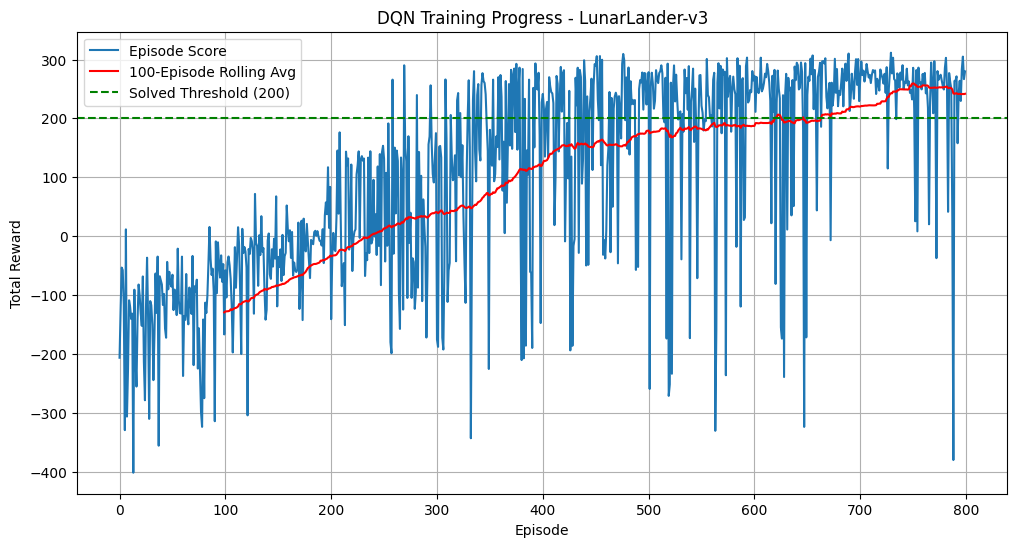

Generating 'wow' GIF of the trained agent...
This may take a minute...
GIF saved to lunar_lander_solved.gif
Final score in GIF: 292.10


--- Section 7: Save Final Model ---
Model weights saved successfully to: dqn_lunar_lander/dqn_lunar_lander.weights.h5

--- PROJECT COMPLETE ---


In [2]:
# ==============================================================================
# SECTION 1: INSTALLS, IMPORTS, AND SETUP (CORRECTED)
# ==============================================================================
print("--- Section 1: Installs and Imports ---")

# --- 1. Install necessary libraries (FIXED) ---
print("Installing libraries: swig, gymnasium[box2d], pygame, imageio...")
!pip install -q swig
!pip install -q gymnasium[box2d] pygame imageio pandas

import gymnasium as gym
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import numpy as np
import random
import collections
import matplotlib.pyplot as plt
import imageio # For saving the GIF
import pandas as pd # For the rolling average
import os # Import os for directory creation

print(f"TensorFlow Version: {tf.__version__}")
print(f"Gymnasium Version: {gym.__version__}")
print("Imports complete.")
print("\n" + "="*80 + "\n")


# ==============================================================================
# SECTION 2: CONSTANTS AND ENVIRONMENT INSPECTION (OPTIMIZED)
# ==============================================================================
print("--- Section 2: Constants and Environment Inspection ---")

# --- 1. Hyperparameters (Optimized for Speed) ---
BUFFER_SIZE = 100000   # Size of the Replay Buffer
BATCH_SIZE = 128       # (Increased) Use GPU more efficiently
GAMMA = 0.99           # Discount factor for future rewards
LEARNING_RATE = 1e-3   # Learning rate
EPSILON_START = 1.0    # Starting value for Epsilon
EPSILON_END = 0.01     # Minimum value for Epsilon
EPSILON_DECAY = 0.995  # Decay rate for Epsilon
TARGET_UPDATE_FREQ = 1000 # How often (in steps) to update the Target Network
NUM_EPISODES = 800     # (Reduced) Max number of games, faster to run

# --- 2. Environment Inspection ---
env = gym.make("LunarLander-v3") # Use v3
STATE_SIZE = env.observation_space.shape[0]
ACTION_SIZE = env.action_space.n

print(f"State Size: {STATE_SIZE}")
print(f"Action Size: {ACTION_SIZE}")

env.close()
print("\n" + "="*80 + "\n")


# ==============================================================================
# SECTION 3: REPLAY BUFFER (FROM SCRATCH)
# ==============================================================================
print("--- Section 3: Defining the Replay Buffer ---")

class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.memory = collections.deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = collections.namedtuple(
            "Experience",
            field_names=["state", "action", "reward", "next_state", "done"]
        )

    def store(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        batch = random.sample(self.memory, k=self.batch_size)

        states = tf.convert_to_tensor(
            np.array([e.state for e in batch]), dtype=tf.float32
        )
        actions = tf.convert_to_tensor(
            np.array([e.action for e in batch]), dtype=tf.int32
        )
        rewards = tf.convert_to_tensor(
            np.array([e.reward for e in batch]), dtype=tf.float32
        )
        next_states = tf.convert_to_tensor(
            np.array([e.next_state for e in batch]), dtype=tf.float32
        )
        dones = tf.convert_to_tensor(
            np.array([e.done for e in batch]), dtype=tf.float32
        )

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

print("ReplayBuffer class defined.")
print("\n" + "="*80 + "\n")


# ==============================================================================
# SECTION 4: Q-NETWORK (DQN MODEL)
# ==============================================================================
print("--- Section 4: Defining the Q-Network ---")

def build_q_network(state_size, action_size):
    """Builds a simple Feed-Forward Neural Network."""
    model = keras.Sequential([
        layers.Input(shape=(state_size,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(action_size, activation='linear') # 'linear' is crucial
    ])
    return model

# --- 1. Create the Main Q-Network and Target Network ---
q_network = build_q_network(STATE_SIZE, ACTION_SIZE)
target_network = build_q_network(STATE_SIZE, ACTION_SIZE)

# --- 2. Optimizer ---
optimizer = Adam(learning_rate=LEARNING_RATE)

# --- 3. Copy Weights ---
target_network.set_weights(q_network.get_weights())

q_network.summary()
print("\n" + "="*80 + "\n")


# ==============================================================================
# SECTION 5: THE DQN TRAINING LOOP (HIGH-SPEED)
# ==============================================================================
print("--- Section 5: Starting DQN Training Loop ---")

# Define the loss function
mse_loss = tf.keras.losses.MeanSquaredError()

# --- 1. Create the HIGH-SPEED, COMPILED learning function ---
@tf.function  # This decorator compiles the function for a massive speedup
def learn(states, actions, rewards, next_states, dones):
    """
    Performs the high-speed GradientTape learning step.
    """
    # --- Calculate the Target Q-Values (Bellman Equation) ---
    # 1. Get the max Q-value for the next_state from the *target network*
    target_q_next = target_network(next_states)
    max_target_q_next = tf.reduce_max(target_q_next, axis=1)

    # 2. Calculate the target Q-value
    # Q_target = reward + gamma * max_Q(next_state) * (1 - done)
    target_q = rewards + (1 - dones) * GAMMA * max_target_q_next

    # --- Train the Main Q-Network ---
    with tf.GradientTape() as tape:
        # 1. Get the model's current Q-value predictions for the batch of states
        current_q_values = q_network(states)

        # 2. Create a mask to select the Q-value for the action taken
        action_mask = tf.one_hot(actions, ACTION_SIZE)

        # 3. Get the Q-value for the action that was *actually* taken
        q_value = tf.reduce_sum(current_q_values * action_mask, axis=1)

        # 4. Calculate the loss (MSE) between the target and the predicted value
        loss = mse_loss(target_q, q_value)

    # 5. Backpropagate the loss
    grads = tape.gradient(loss, q_network.trainable_variables)
    optimizer.apply_gradients(zip(grads, q_network.trainable_variables))


# --- 2. Main Training Loop ---
print(f"Will train for a max of {NUM_EPISODES} episodes...")
print("The environment is 'solved' when the avg score over 100 episodes is >= 200.")

replay_buffer = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE)
all_scores = []
epsilon = EPSILON_START
total_steps = 0
solved = False

for episode in range(1, NUM_EPISODES + 1):
    env_train = gym.make("LunarLander-v3")
    state, _ = env_train.reset()
    total_reward = 0
    done = False

    while not done:
        # --- 1. Choose Action (Epsilon-Greedy) ---
        if np.random.rand() < epsilon:
            action = np.random.randint(ACTION_SIZE)
        else:
            state_tensor = tf.convert_to_tensor(np.array([state]), dtype=tf.float32)
            q_values = q_network(state_tensor) # Use direct call, faster
            action = np.argmax(q_values[0])

        # --- 2. Take Action in Environment ---
        next_state, reward, terminated, truncated, _ = env_train.step(action)
        done = terminated or truncated
        total_reward += reward
        total_steps += 1

        # --- 3. Store Experience ---
        replay_buffer.store(state, action, reward, next_state, done)

        state = next_state

        # --- 4. Learn (if buffer is ready) ---
        if len(replay_buffer) > BATCH_SIZE:
            states, actions, rewards, next_states, dones = replay_buffer.sample()
            learn(states, actions, rewards, next_states, dones) # Call the fast function

        # --- 5. Update Target Network ---
        if total_steps % TARGET_UPDATE_FREQ == 0:
            target_network.set_weights(q_network.get_weights())

    env_train.close()

    # --- End of Episode ---
    all_scores.append(total_reward)
    epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)
    avg_score = np.mean(all_scores[-100:])

    print(f"Episode: {episode:4d} | Score: {total_reward:6.2f} | Avg Score-100: {avg_score:6.2f} | Epsilon: {epsilon:.3f}")

    if avg_score >= 200.0 and not solved:
        print("\n" + "="*40)
        print(f"SOLVED! Avg score of {avg_score:.2f} over 100 episodes.")
        print(f"Solved in {episode} episodes!")
        print("="*40 + "\n")
        solved = True
        if avg_score >= 230: # If it's *really* good, stop
             break

print("Training complete.")
print("\n" + "="*80 + "\n")


# ==============================================================================
# SECTION 6: VISUALIZATION (THE "WOW" PLOT AND GIF)
# ==============================================================================
print("--- Section 6: Visualization ---")

# --- 1. Plot Training Rewards (The "Proof") ---
print("Plotting training rewards...")
plt.figure(figsize=(12, 6))
plt.plot(all_scores, label='Episode Score')
rolling_avg = pd.Series(all_scores).rolling(window=100).mean()
plt.plot(rolling_avg, color='red', label='100-Episode Rolling Avg')
plt.axhline(y=200, color='g', linestyle='--', label='Solved Threshold (200)')
plt.title('DQN Training Progress - LunarLander-v3')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)
plt.savefig('dqn_reward_plot.png')
plt.show()


# --- 2. Create the "Wow" GIF (The "Deliverable") ---
print("Generating 'wow' GIF of the trained agent...")
print("This may take a minute...")

env_render = gym.make("LunarLander-v3", render_mode="rgb_array")
frames = []
state, _ = env_render.reset()
done = False
total_reward = 0

while not done:
    frame = env_render.render()
    frames.append(frame)

    # Choose action 100% greedily
    state_tensor = tf.convert_to_tensor(np.array([state]), dtype=tf.float32)
    q_values = q_network(state_tensor) # Use direct call
    action = np.argmax(q_values[0])

    state, reward, terminated, truncated, _ = env_render.step(action)
    done = terminated or truncated
    total_reward += reward

env_render.close()

# Save the frames as a GIF
GIF_FILENAME = "lunar_lander_solved.gif"
imageio.mimsave(GIF_FILENAME, frames, fps=30)

print(f"GIF saved to {GIF_FILENAME}")
print(f"Final score in GIF: {total_reward:.2f}")
print("\n" + "="*80 + "\n")


# ==============================================================================
# SECTION 7: SAVE FINAL MODEL
# ==============================================================================
print("--- Section 7: Save Final Model ---")

PROJECT_DIR = "dqn_lunar_lander"
os.makedirs(PROJECT_DIR, exist_ok=True)
MODEL_SAVE_PATH = os.path.join(PROJECT_DIR, "dqn_lunar_lander.weights.h5")

q_network.save_weights(MODEL_SAVE_PATH)

print(f"Model weights saved successfully to: {MODEL_SAVE_PATH}")
print("\n--- PROJECT COMPLETE ---")